<a href="https://colab.research.google.com/github/mklead/data_car/blob/main/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mklead/data_car

Cloning into 'data_car'...
remote: Enumerating objects: 3163, done.
remote: Counting objects: 100% (3163/3163), done.
remote: Compressing objects: 100% (3163/3163), done.
remote: Total 3163 (delta 0), reused 3163 (delta 0), pack-reused 0
Receiving objects: 100% (3163/3163), 41.12 MiB | 35.53 MiB/s, done.


In [2]:
!ls data_car

driving_log.csv  IMG


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [4]:
datadir = 'data_car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\mohamad\Desktop\Car_Data\IMG\center_2021_01_03_21_55_41_103.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\left_2021_01_03_21_55_41_103.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\right_2021_01_03_21_55_41_103.jpg,0.0,0.0,0,11.59364
1,C:\Users\mohamad\Desktop\Car_Data\IMG\center_2021_01_03_21_55_41_172.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\left_2021_01_03_21_55_41_172.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\right_2021_01_03_21_55_41_172.jpg,0.0,0.0,0,11.49865
2,C:\Users\mohamad\Desktop\Car_Data\IMG\center_2021_01_03_21_55_41_250.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\left_2021_01_03_21_55_41_250.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\right_2021_01_03_21_55_41_250.jpg,0.0,0.0,0,11.40380
3,C:\Users\mohamad\Desktop\Car_Data\IMG\center_2021_01_03_21_55_41_332.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\left_2021_01_03_21_55_41_332.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\right_2021_01_03_21_55_41_332.jpg,0.0,0.0,0,11.31327
4,C:\Users\mohamad\Desktop\Car_Data\IMG\center_2021_01_03_21_55_41_399.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\left_2021_01_03_21_55_41_399.jpg,C:\Users\mohamad\Desktop\Car_Data\IMG\right_2021_01_03_21_55_41_399.jpg,0.0,0.0,0,11.32538


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_01_03_21_55_41_103.jpg,left_2021_01_03_21_55_41_103.jpg,right_2021_01_03_21_55_41_103.jpg,0.0,0.0,0,11.59364
1,center_2021_01_03_21_55_41_172.jpg,left_2021_01_03_21_55_41_172.jpg,right_2021_01_03_21_55_41_172.jpg,0.0,0.0,0,11.49865
2,center_2021_01_03_21_55_41_250.jpg,left_2021_01_03_21_55_41_250.jpg,right_2021_01_03_21_55_41_250.jpg,0.0,0.0,0,11.40380
3,center_2021_01_03_21_55_41_332.jpg,left_2021_01_03_21_55_41_332.jpg,right_2021_01_03_21_55_41_332.jpg,0.0,0.0,0,11.31327
4,center_2021_01_03_21_55_41_399.jpg,left_2021_01_03_21_55_41_399.jpg,right_2021_01_03_21_55_41_399.jpg,0.0,0.0,0,11.32538


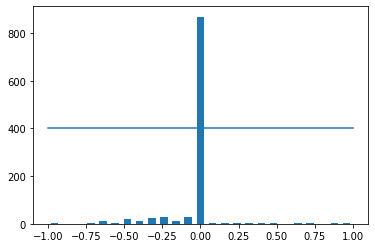

In [6]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [7]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 1054
removed: 469
remaining: 585


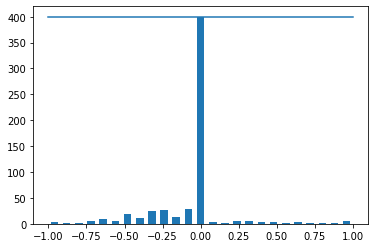

In [8]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[1])

center      center_2021_01_03_21_55_41_399.jpg
left        left_2021_01_03_21_55_41_399.jpg  
right       right_2021_01_03_21_55_41_399.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       11.3254                           
Name: 4, dtype: object


In [11]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1404
Valid Samples: 351


Text(0.5, 1.0, 'Validation set')

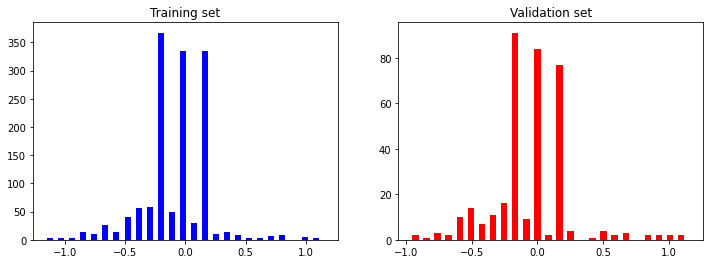

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [19]:
def img_preprocess(img):
  img = mpimg.imread(image)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

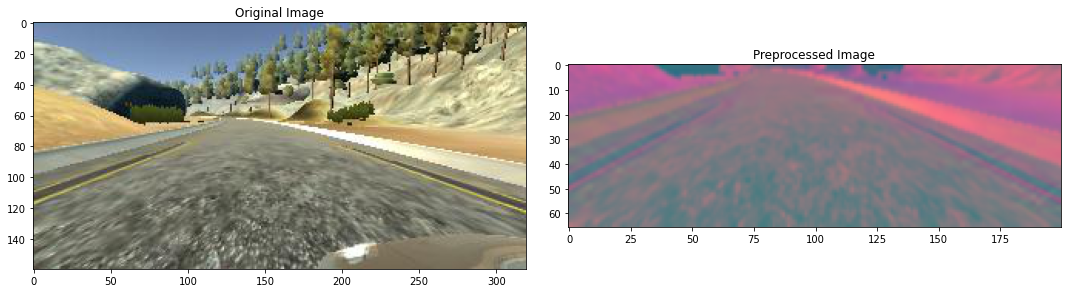

In [20]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

(1404, 66, 200, 3)


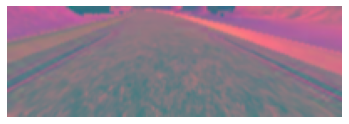

In [21]:
X_train = np.array(list(map(img_preprocess , X_train)))
X_valid = np.array(list(map(img_preprocess , X_valid)))

plt.imshow(X_train[random.randint(0 , len(X_train)-1)])
plt.axis('off')
print(X_train.shape) 
